In [47]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages, StateGraph, StateGraph, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, AIMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
import json


load_dotenv()

model = ChatOpenAI(model ="gpt-4o")

In [48]:
search_tool = TavilySearchResults(max_results=4)

tools = [search_tool]

memory =MemorySaver()

llm_with_tools = model.bind_tools(tools)

In [49]:
llm_with_tools.invoke("What is the current weather in New York?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_n8xzBhn6tFD4Ok8Ewrqcj79H', 'function': {'arguments': '{"query":"current weather in New York City"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 88, 'total_tokens': 111, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_80956533cb', 'id': 'chatcmpl-C5trwxFN7o97ORnwYrVVxPcv9S31I', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--12382773-f97e-4e06-a2da-d470d896b302-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in New York City'}, 'id': 'call_n8xzBhn6tFD4Ok8Ewrqcj79H', 'type': 'tool_call'}], usage_metadata={'input_tok

In [ ]:
import re

def mask_pii(text: str) -> str:
    """Detect and mask PII data in the input text before sending to the LLM."""

    # --- Email ---
    text = re.sub(r'[\w\.-]+@[\w\.-]+\.\w+', '[EMAIL]', text)

    # --- Phone numbers ---
    text = re.sub(r'(\+?\d{1,3})?[\s-]?\(?\d{2,4}\)?[\s-]?\d{3,4}[\s-]?\d{3,4}', '[PHONE]', text)

    # --- Credit card ---
    text = re.sub(r'\b(?:\d[ -]*?){13,16}\b', '[CREDIT_CARD]', text)

    # --- Address masking (allow unit/street + suburb + state + postcode + country) ---
    address_pattern = re.compile(
        r'([\d/]+\s+[\w\s]+,?\s*)([A-Za-z\s]+),\s*([A-Za-z]{2,}|[A-Z]{2,3})\s*(\d{4}),?\s*([A-Za-z\s]+)',
        re.IGNORECASE
    )

    def replace_address(match):
        suburb = match.group(2).strip()
        state = match.group(3).strip()
        postcode = match.group(4).strip()
        country = match.group(5).strip()
        return f"[ADDRESS], {suburb}, {state} {postcode}, {country}"

    text = address_pattern.sub(replace_address, text)

    return text


In [51]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from langgraph.prebuilt import ToolNode

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {
        "messages": [result], 
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END

async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""
    # Get the tool calls from the last message
    tool_calls = state["messages"][-1].tool_calls
    
    # Initialize list to store tool messages
    tool_messages = []
    
    # Process each tool call
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
        
        # Handle the search tool
        if tool_name == "tavily_search_results_json":
            # Execute the search tool with the provided arguments
            search_results = await search_tool.ainvoke(tool_args)
            
            # Create a ToolMessage for this result
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name
            )
            
            tool_messages.append(tool_message)
    
    # Add the tool messages to the state
    return {"messages": tool_messages}

graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges("model", tools_router)
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)

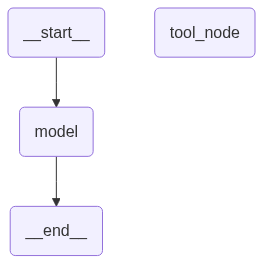

In [52]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [42]:
config = {
    "configurable":{
        "thread_id":5
    }
}

response = await graph.ainvoke({
    "messages": [
        HumanMessage(content="When is the next spacex launch?")]}, config=config)

response


{'messages': [HumanMessage(content="Hi, I'm Aslam?", additional_kwargs={}, response_metadata={}, id='4bd6f73c-ef84-4783-8970-551eec10a740'),
  AIMessage(content='Hello Aslam! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 85, 'total_tokens': 97, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-C5DYzqdi60COLSHcsVGoBeaqtrYSR', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--3fdafd67-29af-4334-9bc2-7effb459135a-0', usage_metadata={'input_tokens': 85, 'output_tokens': 12, 'total_tokens': 97, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(conten

In [66]:
masked_message = mask_pii(
    "My name is Aslam Mohammed, my email is aslamafreed13@gmail.com and my address is "
    "1/13 Iona street, St Kilda, Victoria 3182, Australia."
)

print(masked_message)

config = { 
    "configurable":{
        "thread_id":9
    }
}

events =  graph.astream_events({
    "messages": [
        HumanMessage(content=masked_message)]}, config=config,version="v2")

async for event in events:
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush =True)


My name is Aslam Mohammed, my email is [EMAIL] and my address is [ADDRESS], St Kilda, Victoria 3182, Australia.
Hello Aslam Mohammed! If there's anything you need help with, feel free to let me know.

In [67]:

config = { 
    "configurable":{
        "thread_id":9
    }
}

events =  graph.astream_events({
    "messages": [
        HumanMessage(content="what is my name, email and address ?")]}, config=config,version="v2")

async for event in events:
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush =True)

Your name is Aslam Mohammed. However, I'm unable to recall your email and address from previous interactions. If you provide them again, I'll be happy to assist you with any information or tasks you need help with.